In [1]:
import matplotlib, pathlib, torch, argparse, os, sys, logging
sys.path.append(os.getcwd())
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

import matplotlib.pyplot as plt
import numpy as np
import sigpy as sp

from sigpy import from_pytorch, to_pytorch_function
import fastmri
from torch.autograd import Variable

import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.data import SliceDataset

from torch.utils.data import DataLoader, Dataset
from network import VarNet
import torch

In [138]:
mask_func = subsample.RandomMaskFunc(
    center_fractions=[0.08],
    accelerations=[4]
)

def test_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace)
    masked_kspace, mask = transforms.apply_mask(kspace, mask_func, seed=100)
    
    max_value = data_attributes["max"]
    crop_size = torch.tensor([data_attributes["recon_size"][0], data_attributes["recon_size"][1]])
    target = fastmri.rss(fastmri.complex_abs(fastmri.ifft2c(kspace)), dim=0)

    return masked_kspace, mask.byte(), target, max_value, kspace

In [139]:
net = torch.load('exp/E2EVN_knee2d.pt')

In [140]:
testset = SliceDataset(root= pathlib.Path('data/div_knee2d/Test'), transform=test_transform, challenge='multicoil')

In [141]:
ksp, mask, labels, max_value, ksp_true = testset[10]

print(labels.shape)

torch.Size([640, 372])


In [142]:
tmp = labels.numpy()

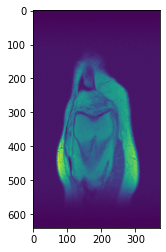

In [143]:
plt.imshow(tmp)

In [144]:
def ifftrecon(ksp):
    ksp_np = from_pytorch(ksp[0].cpu(), iscomplex=True)
    im = sp.ifft(ksp_np,axes=(1,2))
    im_comb = sp.rss(im,axes=0)
    im_comb = sp.resize(im_comb,[320,320])
    return im_comb

In [145]:
from logging import FileHandler
from vlogging import VisualRecord

import logging
logger = logging.getLogger("demo")
fh = FileHandler('test2.html', mode="w")

logger.setLevel(logging.DEBUG)
logger.addHandler(fh)

In [146]:
def test_result(idx, testset, net):
    ksp, mask, labels, max_value, ksp_true = testset[idx]
    ksp = ksp.unsqueeze(0).cuda()
    mask = mask.unsqueeze(0).cuda()
    with torch.no_grad():
        out, _, ksp_out = net(ksp, mask)
    out = transforms.center_crop(out, [320,320])
    out_np = out[0].cpu().detach().numpy()
    zf = ifftrecon(ksp)
    labels = from_pytorch(labels)
    labels = sp.resize(labels,[320,320])
    
    ksp_out_np = from_pytorch(ksp_out[0,0].cpu(), iscomplex=True)
    ksp_out_np = ksp_out_np / max_value # Normalize
    ksp_out_np = np.abs(sp.resize(ksp_out_np,[320,320])) ** 0.2
    ksp_out_np = ksp_out_np * 350

    ksp_np = from_pytorch(ksp[0,0].cpu(), iscomplex=True)
    ksp_np = ksp_np / max_value # Normalize
    ksp_np = np.abs(sp.resize(ksp_np,[320,320])) ** 0.2
    ksp_np = ksp_np * 350

    ksp_true_np = from_pytorch(ksp_true[0], iscomplex=True)
    ksp_true_np = ksp_true_np / max_value # Normalize
    ksp_true_np = np.abs(sp.resize(ksp_true_np,[320,320])) ** 0.2
    ksp_true_np = ksp_true_np * 350
    
    ksp_out_np = np.concatenate((ksp_np, ksp_out_np, ksp_true_np), 1)
    
    out_cat = np.concatenate((zf/max_value, out_np/max_value, labels/max_value),1)
    error_cat = np.concatenate((labels/max_value, labels/max_value, labels/max_value),1)
    error_cat = np.abs(error_cat - out_cat) * 5
    out_cat = np.concatenate((out_cat,error_cat),axis=0)
    out_cat = out_cat * 600
    return out_cat, ksp_out_np

In [147]:
logger.info('hihi')

# SPIRIT refinement

In [148]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sigpy as sp
import sigpy.plot as pl
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

import numpy as np
from skimage.util import pad, view_as_windows
from scipy.linalg import null_space
from cg_spirit_gpu import *
from functools import partial

# This is for GPU version
import fastmri.data.transforms as T
import torch



In [149]:
ksp, mask, labels, max_value, ksp_true = testset[50]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
with torch.no_grad():
    out, _, ksp_out = net(ksp, mask)

In [150]:
print(ksp_out.shape, ksp.shape)

torch.Size([1, 15, 640, 372, 2]) torch.Size([1, 15, 640, 372, 2])


In [151]:
with torch.no_grad():
    ksp_us_vcc = torch_VCC(ksp)
    ksp_out_vcc = torch_VCC(ksp_out)
print(ksp_us_vcc.shape, ksp_out_vcc.shape)

torch.Size([1, 30, 640, 372, 2]) torch.Size([1, 30, 640, 372, 2])


In [152]:
ksp_us_vcc_np = from_pytorch(ksp_us_vcc.cpu().detach(), iscomplex=True)[0]
mask = np.abs(ksp_us_vcc_np) > 0
print(mask.shape)

(30, 640, 372)


# Preparing calibration

In [153]:
# Preparing calibration line 
center_fractions = 0.08

ksp_vn_np = np.moveaxis(from_pytorch(ksp_out_vcc.detach().cpu(),iscomplex=True)[0],0,-1)
print(ksp_vn_np.shape)

nro, npe, ncoil = ksp_vn_np.shape
kernel_size = [5,5]
kx, ky = kernel_size[:]
kx2, ky2 = int(kx/2), int(ky/2)

calib = sp.resize(ksp_vn_np,[round(npe*center_fractions),round(npe*center_fractions),ncoil]) # This is the calibration region

print(mask.shape, calib.shape)

(640, 372, 30)
(30, 640, 372) (30, 30, 30)


In [154]:
# Preparing calibration kernel
algorithm = 'pruno'

if algorithm == 'spirit':
    GOP = spirit_calibrate(calib, kernel_size, lamda=0.01)
    GOP = GOP.copy()
    for n in range(ncoil):
        GOP[n,n,2,2] = -1
    print('SPIRIT kernel: {}'.format(GOP.shape))
else:
    C = view_as_windows(
        calib, (kx, ky, ncoil)).reshape((-1, kx*ky*ncoil))
    n = null_space(C, rcond=1e-3)
    print(n.shape)
    n = n[:,-300:] # choosing only 200
    n = np.reshape(n, (kx, ky, ncoil, n.shape[-1]))
    GOP = np.transpose(n[::-1,::-1],[3,2,0,1])
    print('PRUNO kernel: {}'.format(GOP.shape))

(750, 171)
PRUNO kernel: (171, 30, 5, 5)


In [155]:
GOP_t = T.to_tensor(GOP)
mask_t = T.to_tensor(mask)
mask_t = mask_t.unsqueeze(0).unsqueeze(-1)

# To GPU
GOP_t = GOP_t.type(torch.FloatTensor).to('cuda:0')
mask_t = mask_t.type(torch.FloatTensor).to('cuda:0')

print(GOP_t.shape, mask_t.shape)



torch.Size([171, 30, 5, 5, 2]) torch.Size([1, 30, 640, 372, 1])


In [156]:
%%time

l2lam = 0.2
# This is solving Ax = b by conjugate gradient algorithm
with torch.no_grad():
    ATA = partial(AHA, gop=GOP_t, m=mask_t)
    b = AHb(ksp_us_vcc, mask_t, GOP_t) + l2lam * ksp_out_vcc
    res = conjgrad(30, ATA, b, ksp_us_vcc, l2lam=l2lam, device='cuda:0')

Initial Error: 0.9582642316818237
[Iter:1/30] Error:0.23388516902923584
[Iter:2/30] Error:0.09681271016597748
[Iter:3/30] Error:0.04945122450590134
[Iter:4/30] Error:0.028152046725153923
[Iter:5/30] Error:0.017102858051657677
[Iter:6/30] Error:0.010919958353042603
[Iter:7/30] Error:0.007185604888945818
[Iter:8/30] Error:0.004843639675527811
[Iter:9/30] Error:0.0033303506206721067
[Iter:10/30] Error:0.0023285041097551584
[Iter:11/30] Error:0.0016337645938619971
[Iter:12/30] Error:0.0011386435944586992
[Iter:13/30] Error:0.0007946350378915668
[Iter:14/30] Error:0.0005525081069208682
[Iter:15/30] Error:0.00038021468208171427
[Iter:16/30] Error:0.00026116750086657703
[Iter:17/30] Error:0.00017935685173142701
[Iter:18/30] Error:0.0001229418267030269
[Iter:19/30] Error:8.4177780081518e-05
[Iter:20/30] Error:5.76262355025392e-05
[Iter:21/30] Error:3.946226570405997e-05
[Iter:22/30] Error:2.6937832444673404e-05
[Iter:23/30] Error:1.8305847333977e-05
[Iter:24/30] Error:1.2409936061885674e-05
[I

In [157]:
# Plotting resulting coil combined image
res_vn = out.cpu().detach().numpy().squeeze()
res_np = from_pytorch(res.detach().cpu(),iscomplex=True)[0][:15]
res_vn_spirit = sp.rss(sp.ifft(res_np),0)
print(res_vn_spirit.shape)

(640, 372)


In [158]:
res_vn_spirit = sp.resize(res_vn_spirit,[320,320])
res_vn = sp.resize(res_vn,[320,320])
labels = sp.resize(labels.cpu().numpy(),[320,320])

res_vn_spirit = res_vn_spirit / np.std(res_vn_spirit)
res_vn = res_vn / np.std(res_vn)

labels = labels / np.std(labels)


In [159]:
out_cat = np.concatenate((res_vn, res_vn_spirit, labels), axis=1)
error_cat = np.concatenate((labels,labels,labels),axis=1)
error_cat = np.abs(out_cat-error_cat) * 5
out_cat = np.concatenate((out_cat,error_cat),axis=0)

(-0.5, 959.5, 639.5, -0.5)

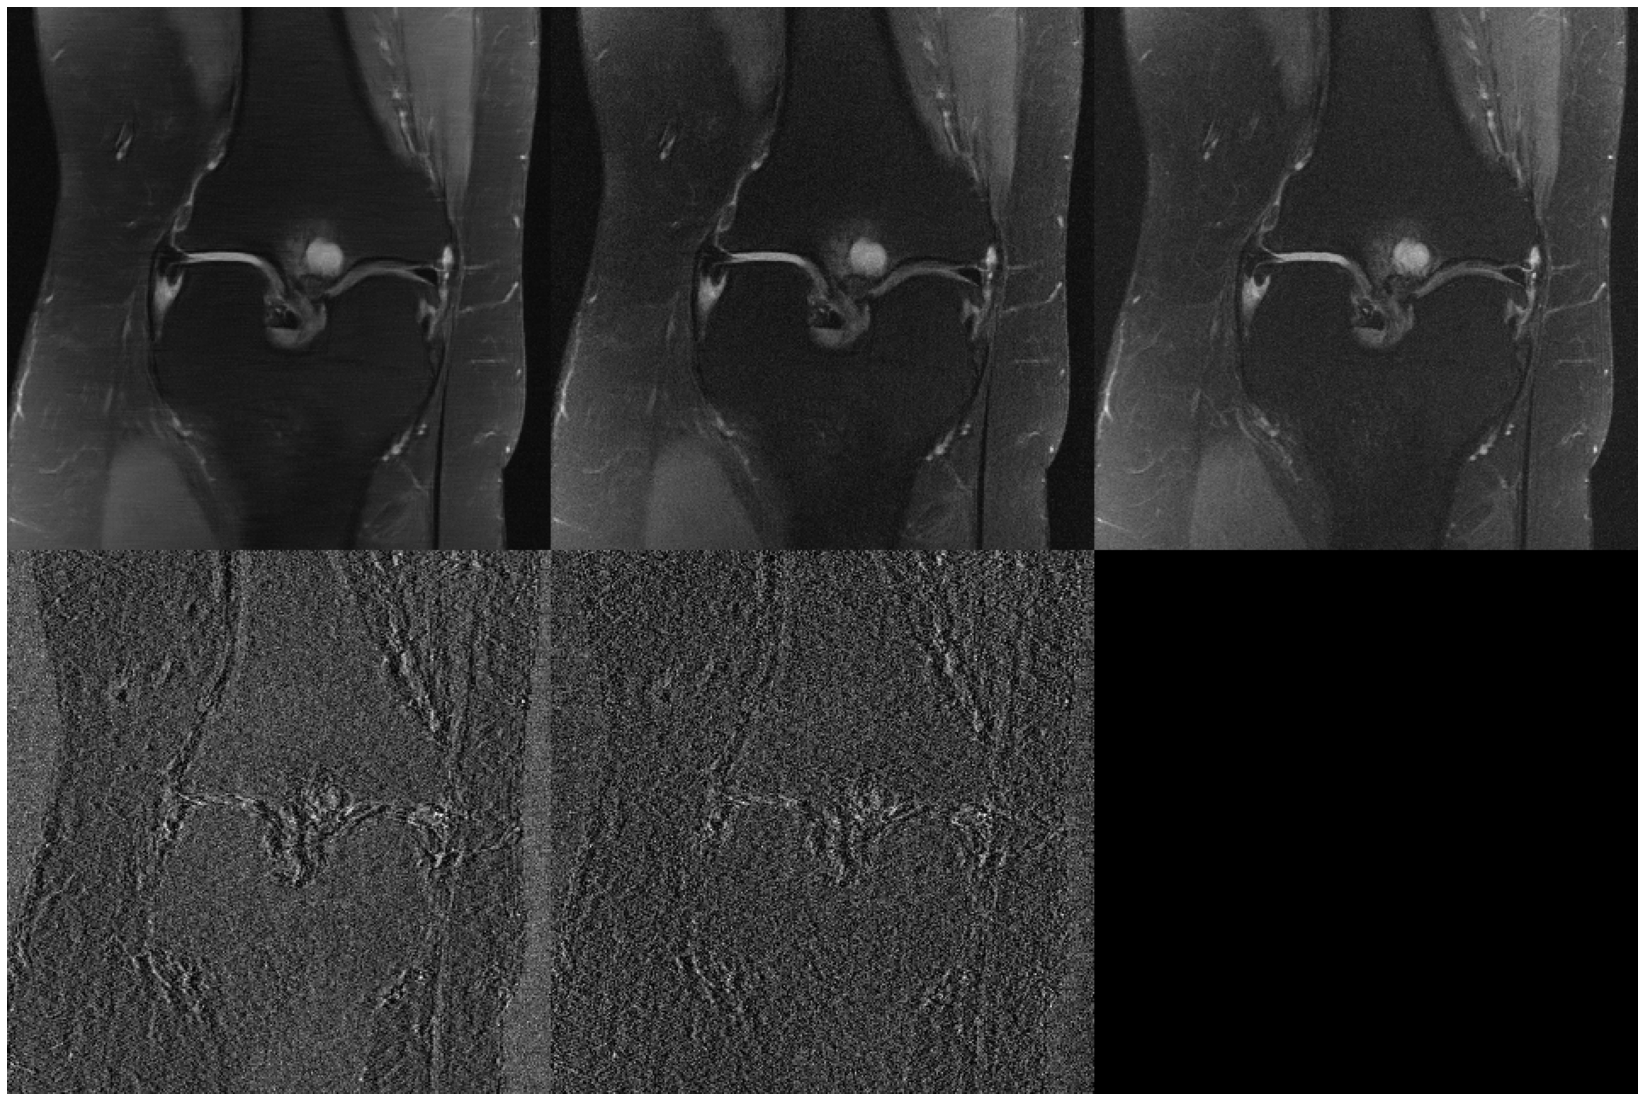

In [160]:
plt.figure(figsize=(30,20))
plt.imshow(out_cat,cmap='gray')
plt.axis('off')


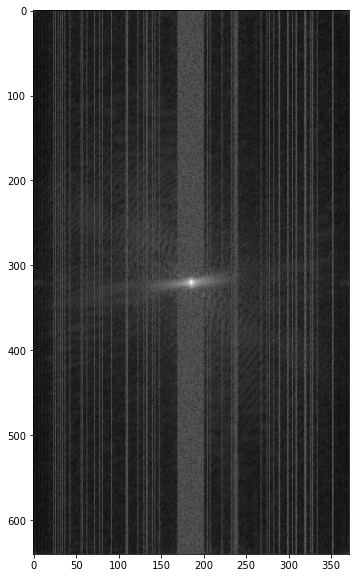

In [161]:
ksp_out_np = from_pytorch(ksp_out[0].cpu().detach(),iscomplex=True)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(ksp_out_np[0])**0.2, cmap='gray')

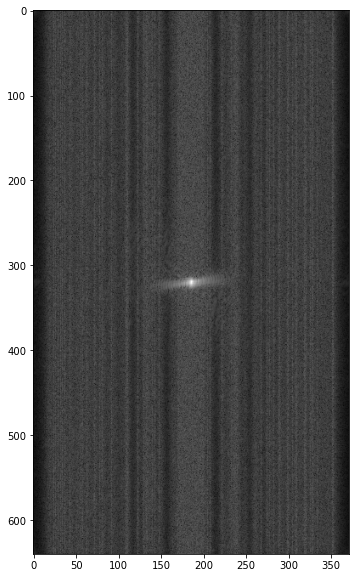

In [162]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(res_np[0])**0.2, cmap='gray')

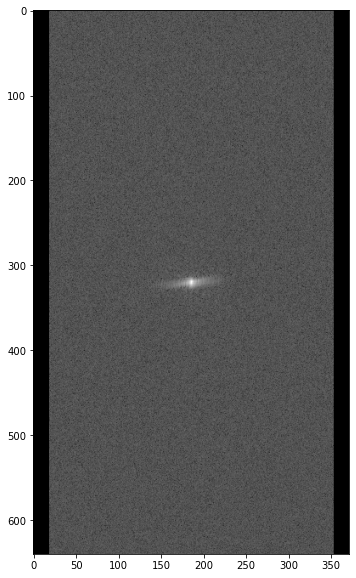

In [163]:
ksp_true_np = from_pytorch(ksp_true[0].cpu().detach(),iscomplex=True)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(ksp_true_np)**0.2, cmap='gray')

# Add final VN block

In [168]:
ksp, mask, labels, max_value, ksp_true = testset[50]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
with torch.no_grad():
    out, _, ksp_out = net(ksp, mask)

In [169]:
sens_maps = net.sens_net(ksp, mask)

In [170]:
last_block = net.cascades[-1]


In [171]:
res2 = last_block(res[:,:15], ksp, mask, sens_maps)

In [172]:
final_im = fastmri.rss(fastmri.complex_abs(fastmri.ifft2c(res2)), dim=1)
final_im = final_im.cpu().detach().numpy().squeeze()
final_im = sp.resize(final_im,[320,320])

print(final_im.shape)

(320, 320)


(-0.5, 319.5, 319.5, -0.5)

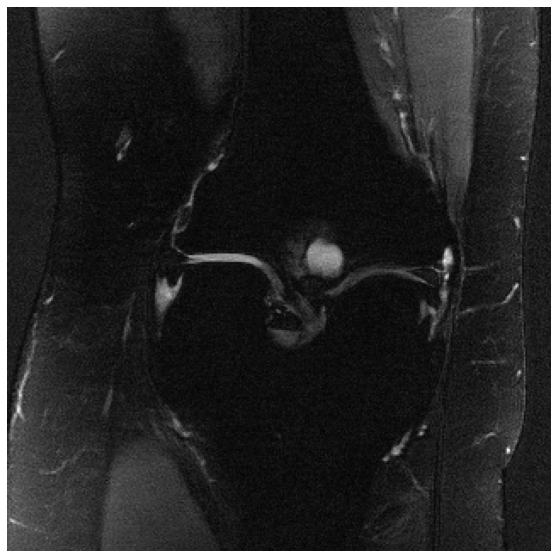

In [173]:
plt.figure(figsize=(10,10))
plt.imshow(final_im, cmap='gray')
plt.axis('off')

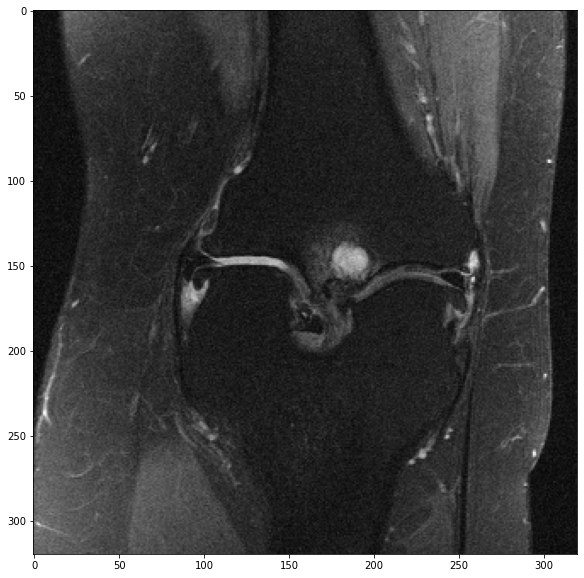

In [167]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(labels), cmap='gray')